In [1]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

## Import the Dataset

In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv', parse_dates=['date'])
test_df = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv', parse_dates=['date'])
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


### Data Preprocessing

In [3]:
def extract_from_date(df):
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['WeekDay'] = df['date'].dt.dayofweek
    
    return df

train_df = extract_from_date(train_df)
test_df = extract_from_date(test_df)

### Model

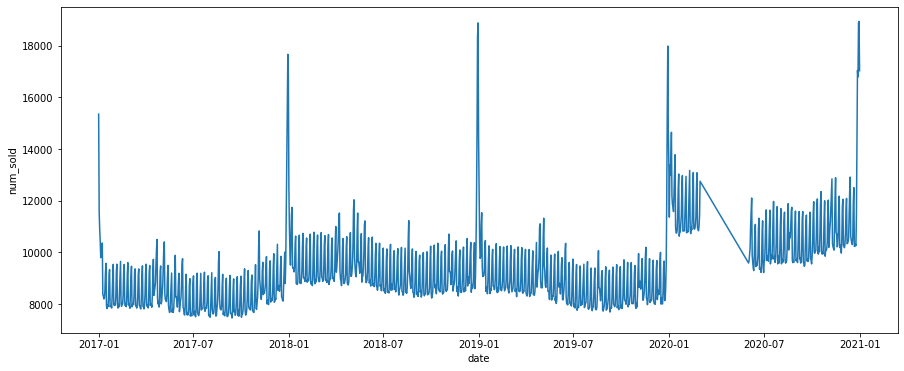

In [4]:
no_covid = train_df.loc[~((train_df['date'] >= "2020-03-01") & (train_df['date'] < "2020-06-01"))]
train_agg = no_covid.groupby(['date'])['num_sold'].sum().reset_index()

f,ax = plt.subplots(figsize=(15,6))
sns.lineplot(data=train_agg, x="date", y="num_sold")
test_agg = test_df.groupby(['date'])['row_id'].first().reset_index().drop(columns='row_id')
test_dates = test_agg[["date"]]

### Feature Engineering

In [5]:
import dateutil.easter as easter

def feature_engineer(df):
    copy_df = df.copy()
    copy_df['month'] = df['date'].dt.month
    copy_df['month_sin'] = np.sin(copy_df['month'] * (2 * np.pi / 12))
    copy_df['month_cos'] = np.cos(copy_df['month'] * (2 * np.pi / 12))
    copy_df['day'] = df['date'].dt.day
    copy_df['day_sin'] = np.sin(copy_df['day'] * (2 * np.pi / 12))
    copy_df['day_of_week'] = df['date'].dt.dayofweek
    copy_df['day_of_week'] = copy_df['day_of_week'].apply(lambda x: 0 if x<=3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    copy_df['day_of_year'] = df['date'].dt.dayofyear
    # if leap year
    copy_df['day_of_year'] = copy_df.apply(lambda x: x['day_of_year']-1 if (x['date'] > pd.Timestamp("2020-02-29") and x['date'] < pd.Timestamp("2021-01-01")) else x['day_of_year'], axis=1)
    copy_df['important_dates'] = copy_df['day_of_year'].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,363,364,365] else 0)
    
    copy_df['year'] = df['date'].dt.year
    
    easter_date = copy_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        copy_df[f'easter_{day}'] = (copy_df.date - easter_date).dt.days.eq(day)
    copy_df = copy_df.drop(columns=['date', 'month', 'day', 'day_of_year'])
    
    for col in copy_df.columns:
        if 'easter' in col:
            copy_df = pd.get_dummies(copy_df, columns = [col], drop_first=True)
    
    copy_df = pd.get_dummies(copy_df, columns=['important_dates', 'day_of_week'], drop_first=True)
    
    return copy_df

In [6]:
train_pred = pd.DataFrame()
train_pred['date'] = train_agg['date']

y_train = train_agg['num_sold']
X_train = train_agg.drop(columns="num_sold")
X_test = test_agg

X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

In [7]:
# KFolds

preds_list = []
# n_splits=4 because we have 4 years
kf = GroupKFold(n_splits=4)
scores = []
train_scores = [0] * len(X_train)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, groups=X_train.year)):
    model = Lasso(tol=0.000001, max_iter=100000, alpha=0.03, random_state=42)
    scale = StandardScaler()
    X_train = pd.DataFrame(scale.fit_transform(X_train, y_train), columns=X_train.columns)
    X_test = pd.DataFrame(scale.transform(X_test), columns=X_test.columns)
    model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    preds_list.append(model.predict(X_test))
    train_scores += model.predict(X_train)/4
    sc = model.score(X_train.iloc[val_idx], y_train.iloc[val_idx])
    scores.append(sc)
    print(fold, sc)
train_pred['num_sold'] = train_scores
print("Mean score", np.mean(scores))

0 -0.6097990026194962
1 0.67574826382352
2 0.7949787079330857
3 -0.6466565109514102
Mean score 0.05356786454642484


In [8]:
preds_df = pd.DataFrame(np.column_stack(preds_list), columns=['2017', '2018', '2019', '2020'])
# average predictions
preds_df['num_sold'] = preds_df.sum(axis=1)/len(preds_list)
test_dates['num_sold'] = preds_df['num_sold']

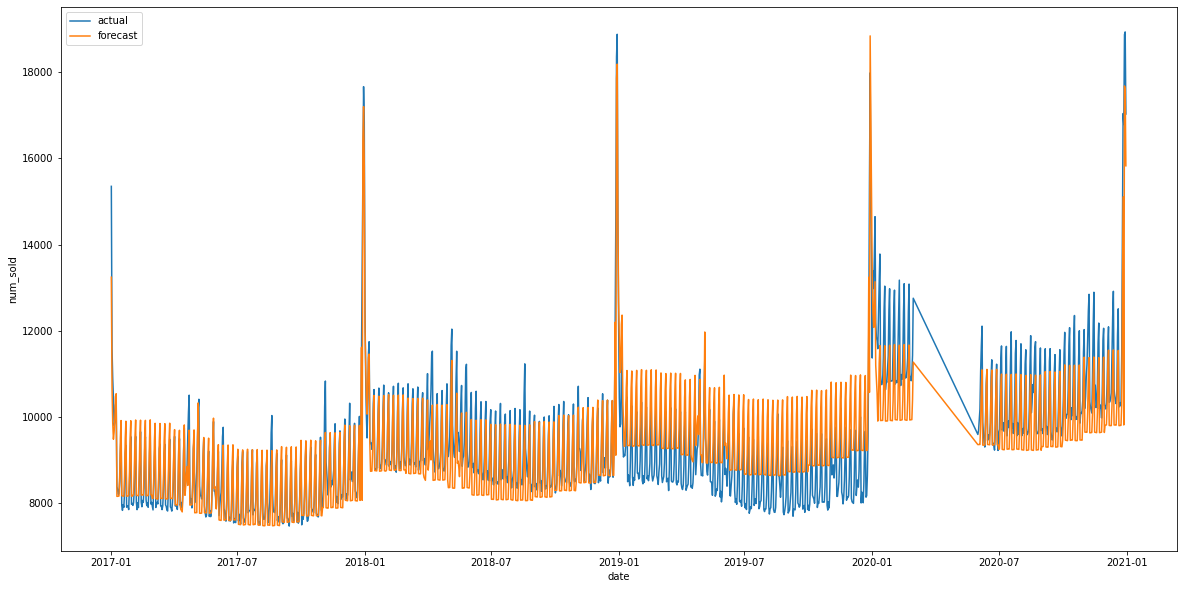

In [9]:
plt.figure(figsize=(20,10))
sns.lineplot(data = train_agg, x="date", y="num_sold", label="actual")
sns.lineplot(data = train_pred, x="date", y="num_sold", label="forecast")
plt.show()

## 2021 Forecasting based on trained model

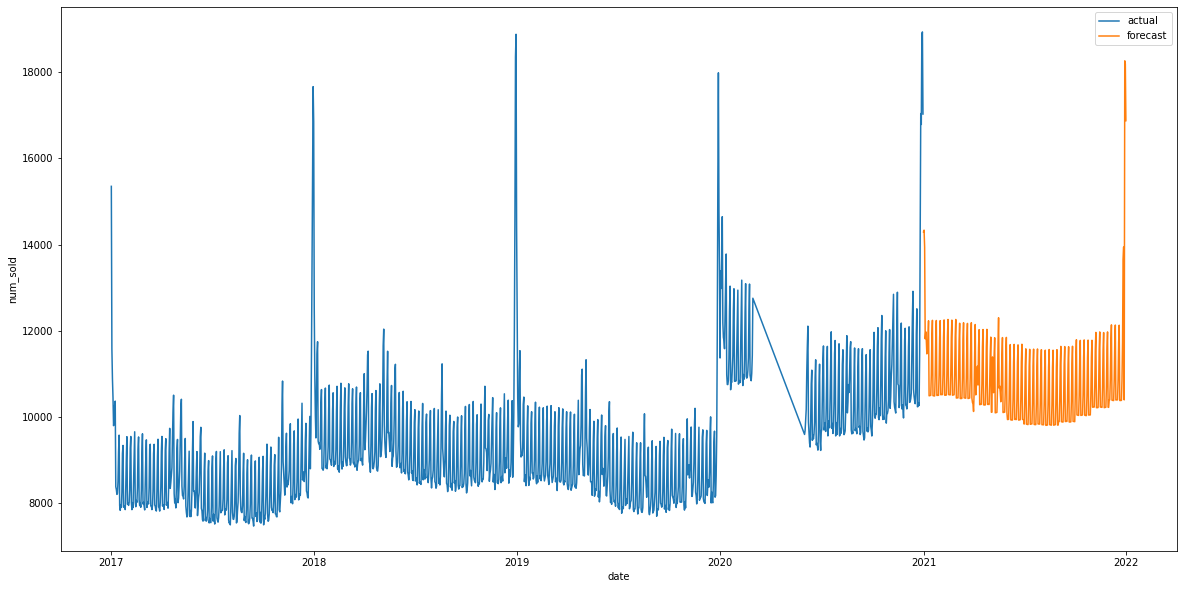

In [10]:
plt.figure(figsize=(20,10))
sns.lineplot(data = train_agg, x="date", y="num_sold", label="actual")
sns.lineplot(data = test_dates, x="date", y="num_sold", label="forecast")
plt.show()

### Improvement with Ratios

In [11]:
product_df = train_df.groupby(["date", "product"])['num_sold'].sum().reset_index()
product_ratiodf = product_df.pivot(index='date', columns='product', values='num_sold')
product_ratiodf = product_ratiodf.apply(lambda x: x/x.sum(), axis=1)
product_ratiodf = product_ratiodf.stack().rename("ratios").reset_index()
product_ratiodf.head()

,date,product,ratios
0,2017-01-01,Kaggle Advanced Techniques,0.277944
1,2017-01-01,Kaggle Getting Started,0.227462
2,2017-01-01,Kaggle Recipe Book,0.188900
3,2017-01-01,Kaggle for Kids: One Smart Goose,0.305693
4,2017-01-02,Kaggle Advanced Techniques,0.280014


In [12]:
mean_ratios = [0] * 1460
for year in train_df['Year'].unique()[:-1]:
    product_ratio2019 = product_ratiodf.loc[product_ratiodf["date"].dt.year == year].copy()
    product_ratio2019['mm-dd'] = product_ratio2019['date'].dt.strftime('%m-%d')
    product_ratio2019 = product_ratio2019.drop(columns='date')
    product_ratio2019 = product_ratio2019.reset_index()
    mean_ratios += product_ratio2019['ratios']

product_ratio2019['mean_ratios'] = mean_ratios/3
    
product_ratio_test = test_df.copy()

product_ratio_test['mm-dd'] = product_ratio_test['date'].dt.strftime('%m-%d')

product_ratio_test = pd.merge(product_ratio_test, product_ratio2019, how='left', on=['mm-dd', 'product'])
product_ratio_test.head()

,row_id,date,country,store,product,Year,Month,Day,WeekDay,mm-dd,index,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4,01-01,2920,0.279273,0.279244
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4,01-01,2921,0.230832,0.227723
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4,01-01,2922,0.188119,0.189136
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4,01-01,2923,0.301776,0.303897
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4,01-01,2920,0.279273,0.279244


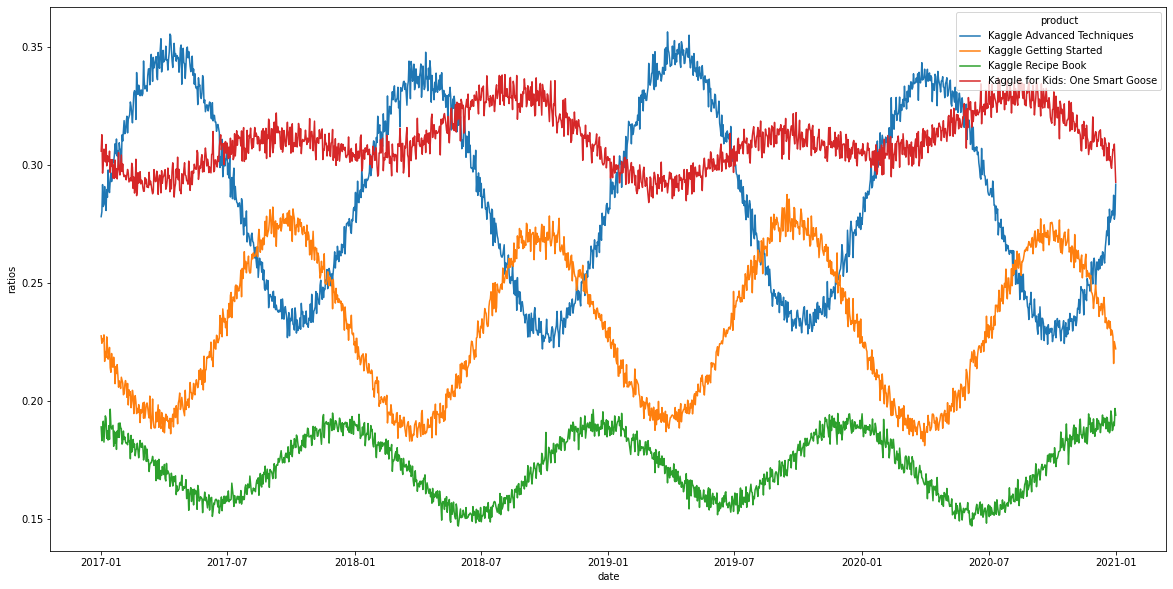

In [13]:
temp = pd.concat([product_ratiodf, test_agg]).reset_index(drop=True)
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = temp, x="date", y="ratios", hue="product")
plt.show()

In [14]:
def disaggregate_forecast(df, original_data):
    copy_df = df.copy()
    
    stores_weights = original_data.groupby("store")['num_sold'].sum()/original_data['num_sold'].sum()
    country_weights = pd.Series(index = df['country'].unique(), data= 1/6)
    
    for country in country_weights.index:
        copy_df.loc[(copy_df['country'] == country), 'num_sold'] = copy_df.loc[(copy_df['country'] == country), 'num_sold'] * country_weights[country]
        
    for store in store_weights.index:
        copy_df.loc[(copy_df['store'] == store), 'num_sold'] = copy_df.loc[(copy_df['store'] == store), 'num_sold'] * store_weights[store]
        
    # apply weights dependant on date
    copy_df['num_sold'] = copy_df['num_sold'] * copy_df['ratios']
    copy_df['num_sold'] = copy_df['num_sold'].round()
    copy_df = copy_df.drop(columns=['ratios'])
    
    return copy_df

In [15]:
test_data = pd.merge(test_df, test_dates, how='left')
test_data['ratios'] = product_ratio_test['mean_ratios']
test_data.head()

,row_id,date,country,store,product,Year,Month,Day,WeekDay,num_sold,ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4,14293.868814,0.279244
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4,14293.868814,0.227723
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4,14293.868814,0.189136
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4,14293.868814,0.303897
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4,14293.868814,0.279244


In [16]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
country_weights = train_df.loc[train_df['date'] < "2020-01-01"].groupby("country")["num_sold"].sum()/train_df.loc[train_df['date'] < "2020-01-01", "num_sold"].sum()

In [17]:
final_df = disaggregate_forecast(test_data, train_df)
final_df

,row_id,date,country,store,product,Year,Month,Day,WeekDay,num_sold
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2021,1,1,4,494.0
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2021,1,1,4,403.0
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2021,1,1,4,335.0
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2021,1,1,4,538.0
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2021,1,1,4,171.0
...,...,...,...,...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,2021,12,31,4,636.0
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,2021,12,31,4,203.0
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle Getting Started,2021,12,31,4,163.0
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle Recipe Book,2021,12,31,4,139.0


In [18]:
submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
submission['num_sold'] = final_df['num_sold']

submission.to_csv('submission.csv', index = False)